In [2]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

### Reading the train and test data

In [7]:
train_dir = r'D:\Data science and ml projects\10. Mood wise Song Detection\train'
test_dir = r'D:\Data science and ml projects\10. Mood wise Song Detection\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


### Data Visualization

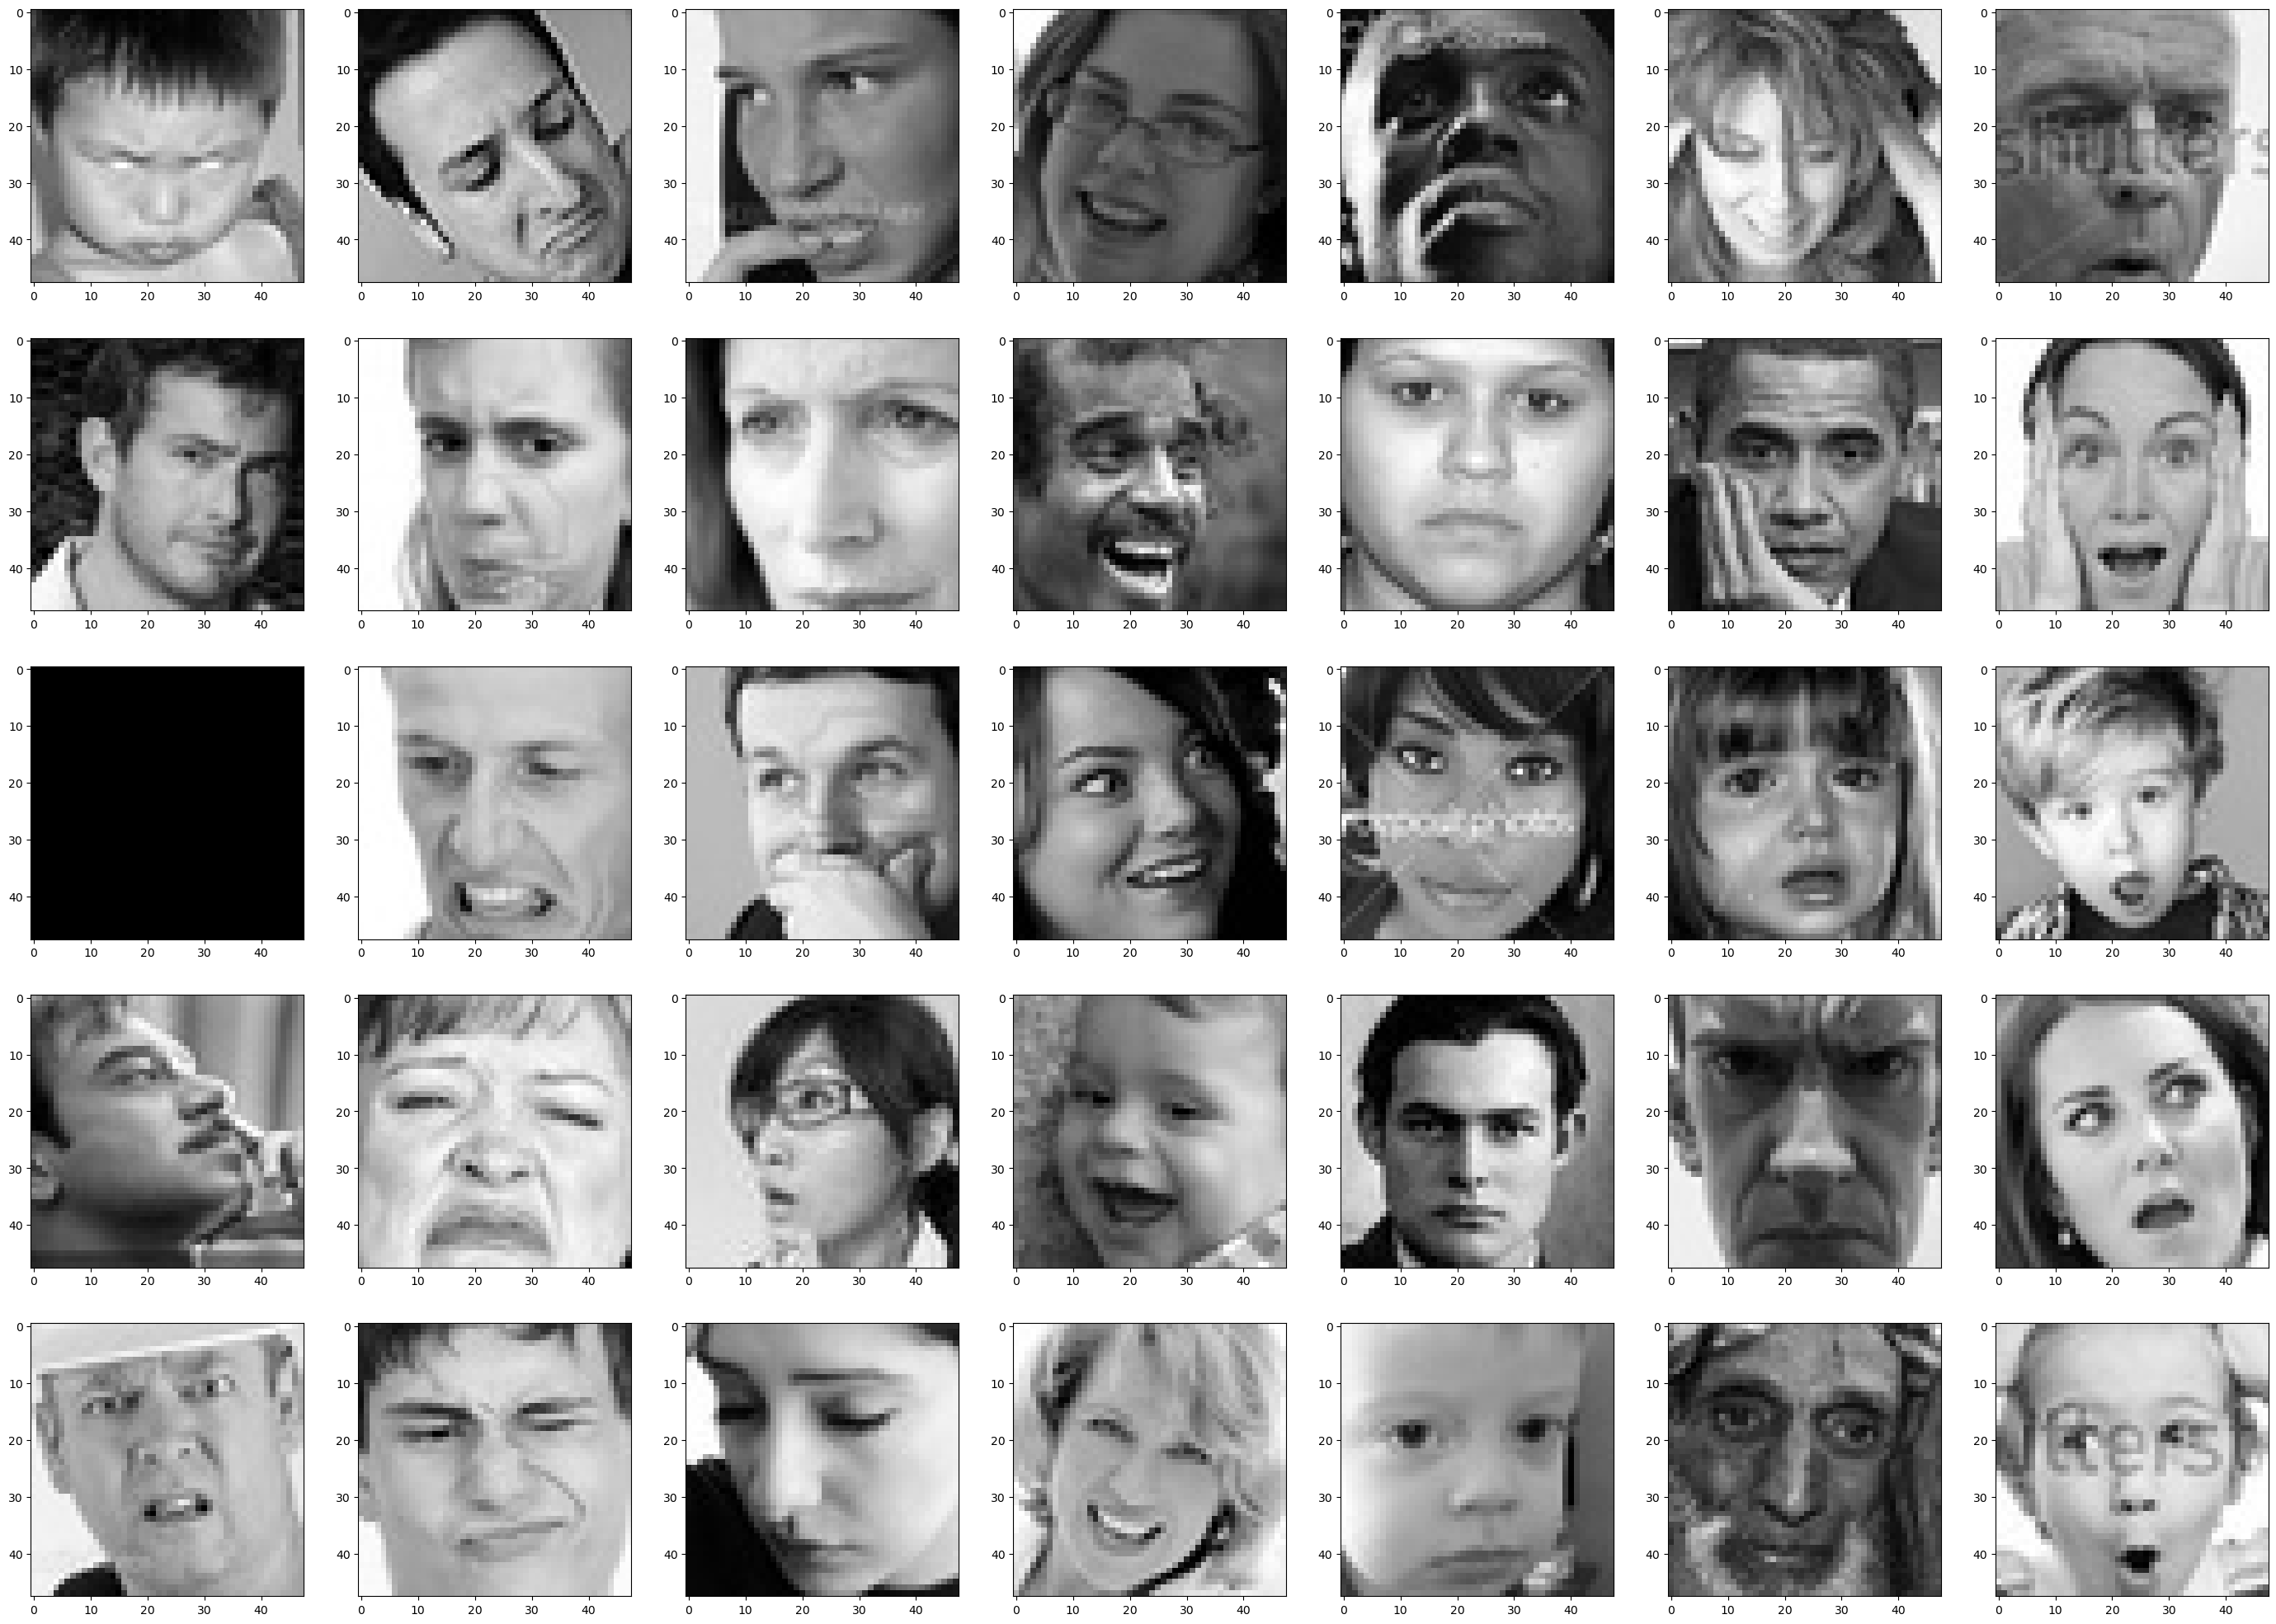

In [8]:
# Data Visualization
from skimage.io import imread
train_dir = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\train\\"
test_dir = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

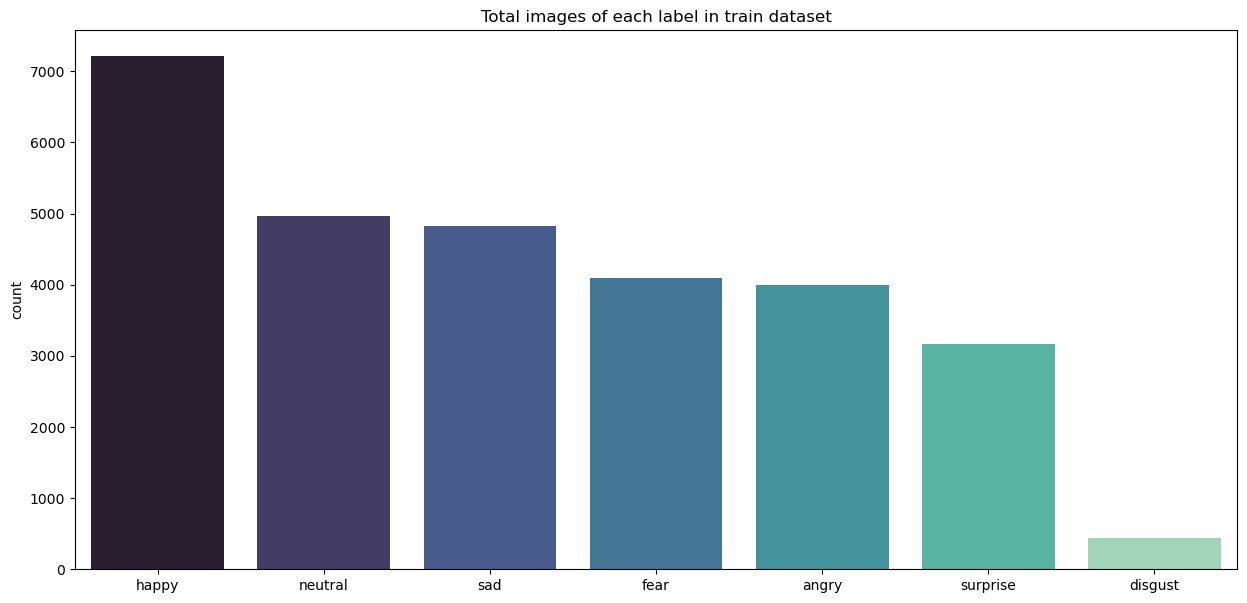

In [9]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

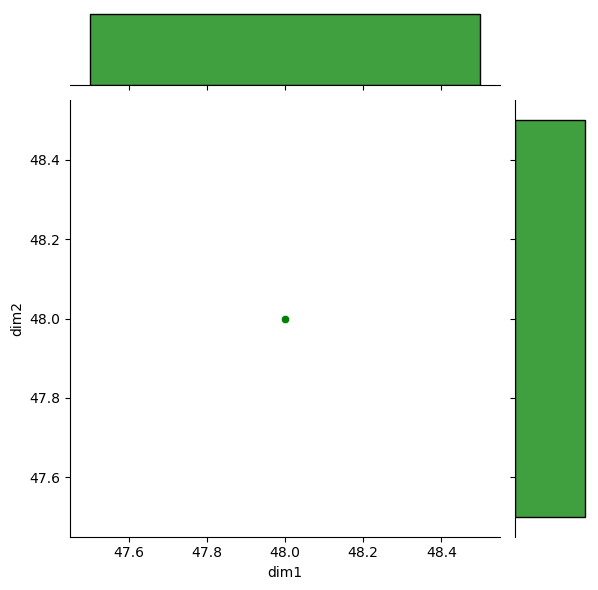

In [11]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='g')
plt.show()

### Data Preprocessing

In [12]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Create the Model

In [13]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

### Training the model

In [14]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 115s 254ms/step - loss: 1.8776 - accuracy: 0.2285 - val_loss: 2.0816 - val_accuracy: 0.2345
Epoch 2/20
448/448 [==============================] - 116s 258ms/step - loss: 1.8044 - accuracy: 0.2443 - val_loss: 1.8069 - val_accuracy: 0.2634
Epoch 3/20
448/448 [==============================] - 116s 258ms/step - loss: 1.7921 - accuracy: 0.2543 - val_loss: 1.7423 - val_accuracy: 0.2846
Epoch 4/20
448/448 [==============================] - 115s 257ms/step - loss: 1.7826 - accuracy: 0.2565 - val_loss: 1.7418 - val_accuracy: 0.2852
Epoch 5/20
448/448 [==============================] - 115s 257ms/step - loss: 1.7706 - accuracy: 0.2692 - val_loss: 1.7235 - val_accuracy: 0.3043
Epoch 6/20
448/448 [==============================] - 112s 251ms/step - loss: 1.7521 - accuracy: 0.2812 - val_loss: 1.7208 - val_accuracy: 0.3142
Epoch 7/20
448/448 [==============================] - 113s 252ms/step - loss: 1.7317 - accuracy: 0.2916 - val_loss: 1.6426 -

In [16]:
model.save("model.h5")

### Evaluating the model

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 8s 67ms/step - loss: 1.2017 - accuracy: 0.5326
validation accuracy : 53.25996279716492%
validation loss : 1.201720118522644


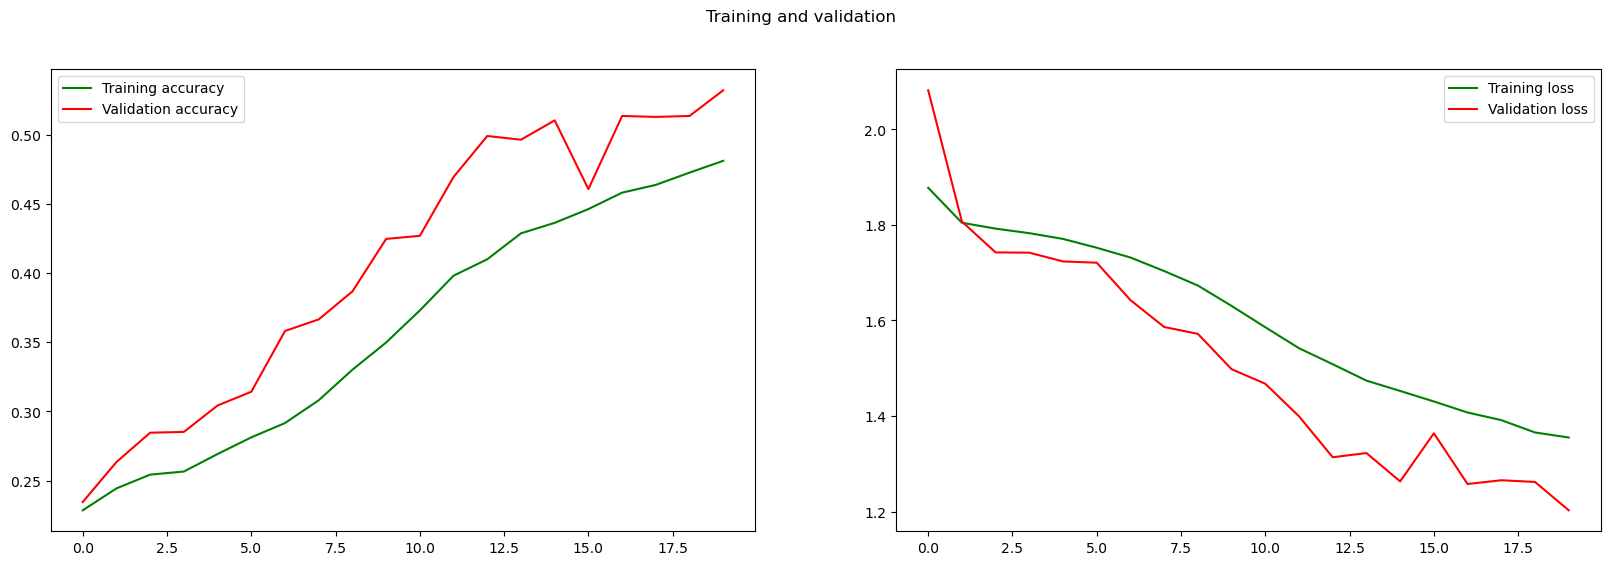

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 8s 67ms/step
              precision    recall  f1-score   support

       angry       0.38      0.49      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.46      0.09      0.15      1024
       happy       0.79      0.79      0.79      1774
     neutral       0.41      0.70      0.52      1233
         sad       0.44      0.29      0.35      1247
    surprise       0.62      0.75      0.68       831

    accuracy                           0.53      7178
   macro avg       0.44      0.45      0.42      7178
weighted avg       0.53      0.53      0.50      7178





C:\Users\987ta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\987ta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\987ta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


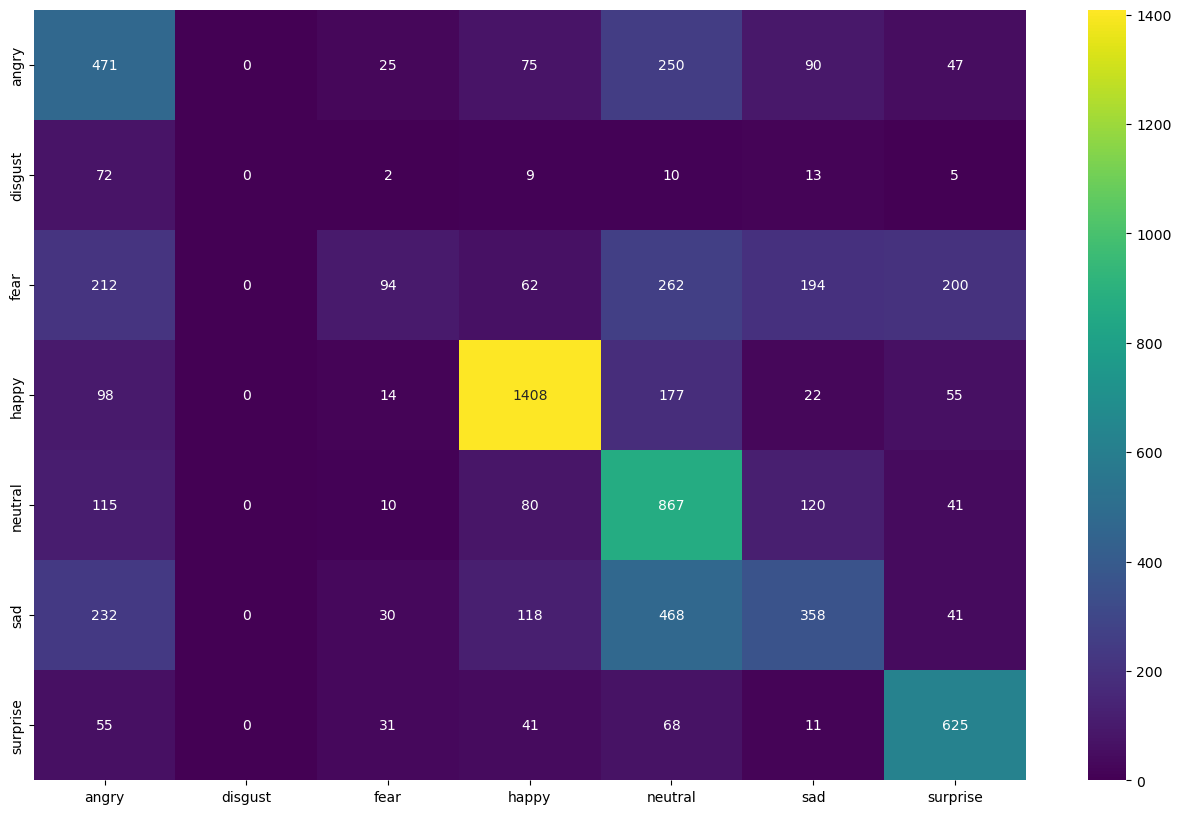

In [38]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

### Testing our model with new image

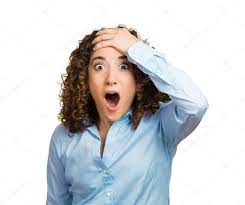

In [48]:
# Testing our model with new image
image = cv2.imread("D:\\Data science and ml projects\\10. Mood wise Song Detection\\surprise.jpg")
from IPython.display import Image
Image(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\surprise.jpg')

In [49]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
model = tf.keras.models.load_model("model.h5",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 126ms/step
  Angry    prediction rate is   0.17%
 Disgust   prediction rate is   0.04%
  Happy    prediction rate is   0.15%
   Sad     prediction rate is   0.11%
 Surprise  prediction rate is   0.24%
 Neutral   prediction rate is   0.21%


 The system considers this expression to be: Surprise


In [55]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Angry"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Angry\\' + d, autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Disgust\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Disgust\\' + d, autoplay=True)
    display(audio)

elif label == "Happy":
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Happy\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Happy\\' + d, autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Sad\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Sad\\' + d, autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Surprise\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Surprise\\' + d, autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Neutral\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='D:\\Data science and ml projects\\10. Mood wise Song Detection\\songs\\Neutral\\' + d, autoplay=True)
    display(audio)

Now Playing: Surprise.mp3
